In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TRANSFORMERS_CACHE'] = './hfcache_proj'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
cache_dir = "hfcache_proj"

In [44]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from datasets import load_metric, Dataset, DatasetDict

from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

import torch.nn as nn
import torch.nn.functional as F

In [45]:
from sklearn.preprocessing import LabelEncoder

In [46]:
device = torch.device('cuda:0')

In [47]:
model_name = "ai-forever/ruRoberta-large"
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir, device_map=device, )
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4, cache_dir=cache_dir, device_map=device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
for param in list(model.parameters())[:180]:
    param.requires_grad = False

In [51]:
df = pd.read_csv('../../data/2_preprocessed_data.csv', usecols=['data_patterns', 'Category']).rename(\
    columns={'data_patterns':'text', 'Category': 'labels'})

le = LabelEncoder()
le.fit(df['labels'])

df['labels'] = le.transform(df['labels'])

In [52]:
le.classes_

array(['Видео', 'ДЗ', 'Лонгрид', 'Тест'], dtype=object)

In [54]:
full_dataset = Dataset.from_pandas(df)
full_dataset = full_dataset.class_encode_column("labels")

Stringifying the column: 100%|█| 39772/39772 [00:00<00:00, 261738.45 ex
Casting to class labels: 100%|█| 39772/39772 [00:00<00:00, 162551.17 ex


In [55]:
dataset = full_dataset.train_test_split(test_size=0.15, stratify_by_column="labels")

test_dataset = dataset['test']

temp_dataset = dataset['train'].train_test_split(test_size=0.2, stratify_by_column="labels")
val_dataset = temp_dataset['test']
train_dataset = temp_dataset['train']

In [56]:
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 27044
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 6762
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 5966
    })
})

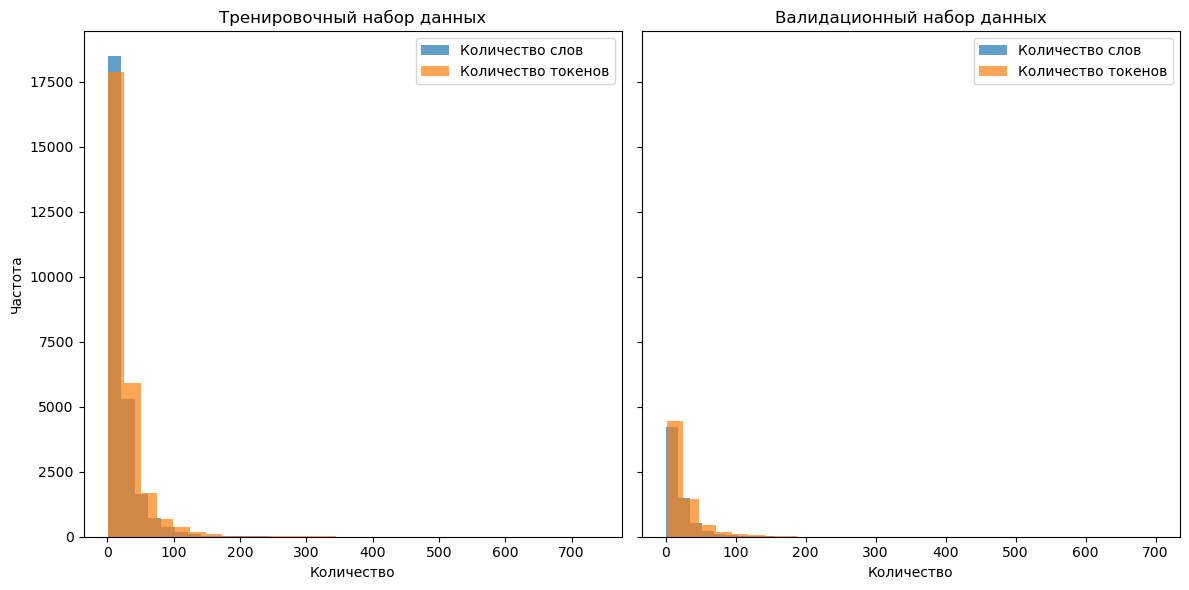

In [21]:
train_word_counts = [len(example['text'].split()) for example in dataset['train']]
train_token_counts = [len(tokenizer.tokenize(example['text'])) for example in dataset['train']]

val_word_counts = [len(example['text'].split()) for example in dataset['validation']]
val_token_counts = [len(tokenizer.tokenize(example['text'])) for example in dataset['validation']]

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Гистограмма для тренировочного набора данных
axes[0].hist(train_word_counts, bins=30, alpha=0.7, label='Количество слов')
axes[0].hist(train_token_counts, bins=30, alpha=0.7, label='Количество токенов')
axes[0].set_title('Тренировочный набор данных')
axes[0].set_xlabel('Количество')
axes[0].set_ylabel('Частота')
axes[0].legend()

# Гистограмма для тестового набора данных
axes[1].hist(val_word_counts, bins=30, alpha=0.7, label='Количество слов')
axes[1].hist(val_token_counts, bins=30, alpha=0.7, label='Количество токенов')
axes[1].set_title('Валидационный набор данных')
axes[1].set_xlabel('Количество')
axes[1].legend()

plt.tight_layout()
plt.show()

In [57]:
# токенизируем и удаляем тексты из датасета
dataset = dataset.map(lambda e:
                      tokenizer(e['text'],
                                truncation = True,
                                max_length=300,
                                padding='max_length'), batched=True)

dataset = dataset.remove_columns('text')
dataset.set_format(type='torch', device=device)

Map: 100%|████████████████| 5966/5966 [00:01<00:00, 5491.28 examples/s]


In [60]:
# Загрузка метрики вне функции
f1_metric = load_metric("f1")

# Параметры обучения
training_args = TrainingArguments(
    output_dir="./results_skil_robert",
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=400,
    weight_decay=0.01,
    logging_dir="./runs",
    logging_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    no_cuda=False, 
    dataloader_pin_memory=False,
    label_names=["labels"]
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    

trainer = Trainer(
    model=model,
    args=training_args
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics,
)

In [61]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,0.641100,0.531991,0.795569
2,0.501000,0.524459,0.804535
3,0.442500,0.557767,0.789004
4,0.391800,0.519331,0.819120
5,0.308600,0.591600,0.822505
6,0.233500,0.633654,0.821591
7,0.183200,0.736141,0.812794
8,0.129600,0.998402,0.812360
9,0.098100,1.051087,0.814233
10,0.074600,1.125006,0.818277


TrainOutput(global_step=8460, training_loss=0.2932224334554469, metrics={'train_runtime': 3517.0794, 'train_samples_per_second': 76.893, 'train_steps_per_second': 2.405, 'total_flos': 1.47675715442208e+17, 'train_loss': 0.2932224334554469, 'epoch': 10.0})

In [62]:
trainer.predict(dataset["test"])

PredictionOutput(predictions=array([[ 4.3213863 , -1.2172418 ,  0.37269413, -2.7528274 ],
       [ 5.2564044 , -1.3465083 , -0.09133258, -2.6018078 ],
       [ 4.9060407 , -0.46405196, -0.91469896, -2.552254  ],
       ...,
       [ 3.8706305 , -1.5212557 ,  0.13023058, -1.7719686 ],
       [ 1.0918226 ,  1.1913091 ,  0.03917417, -2.4226213 ],
       [-1.4355026 ,  6.7053466 , -2.8152878 , -2.9708414 ]],
      dtype=float32), label_ids=array([0, 0, 0, ..., 0, 3, 1]), metrics={'test_loss': 0.5647881031036377, 'test_f1': 0.8267610995525422, 'test_runtime': 32.3087, 'test_samples_per_second': 184.656, 'test_steps_per_second': 11.545})

In [63]:
# model_path = "./skil_save_robert"
# trainer.save_model(model_path)